# Neural Network from scratch using only numpy.

In [1]:
#Importing libraries.
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import torchvision.datasets as datasets
import torchvision.transforms as transforms

%matplotlib inline

SEED = 42 # set random seed to 42

Helper function to plot decision boundary.

In [2]:
def plot_decision_boundary(pred_func, x_min, x_max, y_min, y_max, cmap, ax):
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.flatten(), yy.flatten()])
    Z = Z.reshape(xx.shape)
    # Plot the contour
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)

Helper function to plot the losses.

In [7]:
import time

def plot_losses(train_hist, val_hist):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_hist) + 1)
    plt.plot(epochs, train_hist, 'b-', label='Training Loss')
    plt.plot(epochs, val_hist, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.show()

## Neural Network class:

In [ ]:
class NeuralNetwork():
    @staticmethod
    def len_check(y_pred,y_true):
        prediction_dim = y_pred.shape
        true_dim = y_true.shape
        if (prediction_dim!=true_dim):
            print(f'length of y_pred is {prediction_dim} while length of y_true is {true_dim}, there is a length mismatch. Raising error!')
            raise RuntimeError
        else:
            return

    @staticmethod
    def cross_entropy_loss(y_pred, y_true)->float:
        #Must be passed the softmax activation
        row_wiseSummed = np.sum(y_true*np.log(y_pred + 1e-12),axis=1)
        loss = -np.mean(row_wiseSummed)
        return loss
    
    @staticmethod
    def grad_CE(y_pred,y_true)->np.ndarray:
        grad = (y_pred-y_true)/y_true.shape[0]
        return grad


    @staticmethod
    def mean_squared_loss(y_pred, y_true)->float:
        #1/N * summation (y_hat - y)^2
        loss = np.mean((y_pred-y_true)**2)
        return loss
    
    @staticmethod
    def gradMSE(y_pred,y_true)->np.ndarray:
        grad = 2*(y_pred-y_true)/y_true.shape[0]
        return grad

    @staticmethod
    def accuracy(y_pred, y_true)->np.ndarray:
        correct_preds = np.sum((y_pred.flatten()==y_true.flatten()))
        total_preds = len(y_pred)
        accuracy = (correct_preds/total_preds)*100
        return accuracy

    @staticmethod
    def softmax(x)->np.ndarray:
        x = x-np.max(x,axis=1,keepdims=True)
        sum_ofExps = np.sum(np.exp(x),axis=1,keepdims=True)
        softmax_vals = np.exp(x)/sum_ofExps
        return softmax_vals

    @staticmethod
    def sigmoid(x)->np.ndarray:
        #clipping results for numerical stability
        x=np.clip(x,-500,500)
        activations = 1/(1+np.exp(-x))
        return activations
    
    @staticmethod
    def grad_sigmoid(sigmoid)->np.ndarray:
        grad = sigmoid*(1-sigmoid)
        return grad
    
    @staticmethod
    def Tanh(x)->np.ndarray:
        #clipping results for numerical stability
        x = np.clip(x,-500,500)
        activations = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        return activations
    
    @staticmethod
    def grad_Tanh(tanh)->np.ndarray:
        grad = 1-(tanh**2)
        return grad

    @staticmethod
    def ReLU(x)->np.ndarray:
        activations = np.where(x>0,x,0)
        return activations
    
    @staticmethod
    def grad_ReLU(x)->np.ndarray:
        grad = np.where(x>0,1,0)
        return grad

    def Leaky_ReLU(self, x)->np.ndarray:
        activations = np.where(x>0,x,self.leaky_slope*x)
        return activations
    
    def grad_LeakyRELU(self,x)->np.ndarray:
        grad = np.where(x>0,1,self.leaky_slope)
        return grad
    
    def __init__(self, nodes_per_layer: list[int], mode: str = 'classification', optimizer: str = 'fullbatch', activation: str = 'sigmoid', batch_size: int = 64):
        '''Creates a Feed-Forward Neural Network.
        "nodes_per_layer" is a list containing the number of nodes in each layer (including the input layer) e.g. [2, 10, 10, 2] (2 features, 2 hidden layers with 10 neurons each, 2 classes)"
        '''

        if len(nodes_per_layer) < 2:
            raise ValueError('Network must have at least 2 layers (input and output).')
        if not (np.array(nodes_per_layer) > 0).all():
            raise ValueError('The number of nodes in all layers must be positive.')

        assert mode.lower() in ['classification', 'regression'], "Only classification and regression modes are supported"
        assert optimizer.lower() in ['sgd', 'minibatch', 'fullbatch'], 'Unknown Optimizer'
        assert activation.lower() in ['sigmoid', 'relu', 'leaky_relu','tanh'], 'Unknown activation function'

        self.num_layers = np.size(nodes_per_layer)
        self.mode = mode
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = nodes_per_layer[0]
        self.output_shape = nodes_per_layer[-1]
        self.optimizer = optimizer
        self.activation_strat = activation
        self.batch_size = batch_size

        if activation == 'leaky_relu':
            self.leaky_slope = 0.05

        # Initialize all weights based on a standard normal distribution and all biases to 0.
        self.weights_ = []
        self.biases_ = []
        self.__init_weights(nodes_per_layer)


    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on a standard normal distribution and all biases to 0.'''
        np.random.seed(SEED)
        for i, _ in enumerate(nodes_per_layer):
            if i == 0:
                # skip the input layer; it does not have weights/bias
                continue

            weight_matrix = np.random.normal(size=(nodes_per_layer[i-1], nodes_per_layer[i]))
            self.weights_.append(weight_matrix)
            bias_vector = np.zeros(shape=(nodes_per_layer[i],1))
            self.biases_.append(bias_vector)


    def activaton(self,z):
        if self.activation_strat.lower() == 'sigmoid':
            return NeuralNetwork.sigmoid(z)
        elif self.activation_strat.lower() == 'tanh':
            return NeuralNetwork.Tanh(z)
        elif self.activation_strat.lower() == 'relu':
            return NeuralNetwork.ReLU(z)
        elif self.activation_strat.lower() == 'leaky_relu':
            return self.Leaky_ReLU(z)
        
    def grad_activation(self,activation=0,pre_activation=0):
        if self.activation_strat.lower() == 'sigmoid':
            return NeuralNetwork.grad_sigmoid(activation)
        elif self.activation_strat.lower() == 'tanh':
            return NeuralNetwork.grad_Tanh(activation)
        elif self.activation_strat.lower() == 'relu':
            return NeuralNetwork.grad_ReLU(pre_activation)
        elif self.activation_strat.lower() == 'leaky_relu':
            return self.grad_LeakyRELU(pre_activation)
        
    def Loss_func(self,y_pred,y_true):
        if self.mode.lower() == 'classification':
            y_pred = self.softmax(y_pred)
            return NeuralNetwork.cross_entropy_loss(y_pred,y_true)
        else:
            return NeuralNetwork.mean_squared_loss(y_pred,y_true)
        
    def Loss_funcGrad(self,y_pred,y_true):
        if self.mode.lower() == 'classification':
            y_pred=self.softmax(y_pred)
            return NeuralNetwork.grad_CE(y_pred,y_true)
        else:
            return NeuralNetwork.gradMSE(y_pred,y_true)
        
    def makeOneHot(self,Y):
        total_classes = np.unique(Y).shape[0]
        size = len(Y)
        onehot = np.zeros((size,total_classes))
        for idx in range(size):
            onehot[idx][Y[idx]] = 1
        return onehot
    
    def create_batches(self,x_train,y_train):
      indices = np.arange(x_train.shape[0])
      np.random.shuffle(indices)
      batches_needed = x_train.shape[0]//self.batch_size
      batches = []
      for i in range(0,x_train.shape[0],self.batch_size):
        end_point = i+self.batch_size
        batch_indices = indices[i:end_point]
        x_batch = x_train[batch_indices]
        x_batch = x_batch.reshape(len(x_batch), -1)
        y_batch = y_train[batch_indices]
        if y_batch.ndim == 1 or y_batch.shape[1] == 1:
            y_batch = y_batch.reshape(-1, 1)
        batches.append((x_batch,y_batch))
        if(len(batches)==batches_needed):
          break
      return batches

    def fit(self, Xs, Ys, X_val, Y_val, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr".
        Returns list containing loss for each epoch.'''
        self.history = []
        self.val_history = []
        self._run_optimizer(Xs,Ys, X_val, Y_val, epochs, lr)
        return self.history, self.val_history
    
    def _run_optimizer(self, Xs, Ys, X_val, Y_val, epochs, lr):
        ''' Executes the gradient descent algorithm '''
        # Add functionality for converting integer labels to one-hot labels (optional)
        if self.mode == 'classification' and self.nodes_per_layer[-1]>1:
            Ys = self.makeOneHot(Ys)

        if self.optimizer == 'fullbatch':
            for epoch in tqdm(range(epochs)):
                activations = self.forward_pass(Xs) # Forward Pass over whole dataset
                deltas = self.backward_pass(Ys, activations,Xs) # Backward pass takes layer activations and true labels as input
                self.parameter_update(deltas,lr) # Weight update
                preds = self.forward_pass(Xs)[-1][1] # Make prediction on input sample
                current_loss = self.Loss_func(preds,Ys)
                if epoch%50==0:
                    print(f'epoch {epoch} training loss = {current_loss}')
                self.history.append(current_loss)
                # Compute Validation Loss at the end of each epoch
                val_loss,acc = self.evaluate(X_val,Y_val)
                if epoch%50==0:
                    print(f'epoch {epoch} val loss={val_loss}, val acc = {acc}')
                self.val_history.append(val_loss)

        elif self.optimizer == 'sgd':
            # Code Here
            total_idx = Xs.shape[0]
            idxs = np.arange(total_idx)
            for epoch in tqdm(range(epochs)):
                epoch_loss = 0
                np.random.shuffle(idxs)
                for i in idxs:
                    X = Xs[i:i+1]
                    Y = Ys[i:i+1]
                    activations = self.forward_pass(X)
                    deltas = self.backward_pass(Y, activations,X)
                    self.parameter_update(deltas,lr)
                    preds = self.forward_pass(X)[-1][1]
                    current_loss = self.Loss_func(preds,Y)
                    epoch_loss += current_loss
                if epoch%50==0:
                    print(f'epoch {epoch} training loss = {epoch_loss/total_idx}')
                self.history.append(epoch_loss/total_idx)
                val_loss,acc = self.evaluate(X_val,Y_val)
                if epoch%50==0:
                    print(f'epoch {epoch} val loss={val_loss}, val acc = {acc}')
                self.val_history.append(val_loss)


        elif self.optimizer == 'minibatch':
            # Code Here
            batches = self.create_batches(Xs,Ys)
            batches = np.array(batches)
            for epoch in tqdm(range(epochs)):
                np.random.shuffle(batches)
                epoch_loss=0
                for batch in batches:
                    X,Y = batch
                    activations = self.forward_pass(X)
                    deltas = self.backward_pass(Y, activations,X)
                    self.parameter_update(deltas,lr)
                    preds = self.forward_pass(X)[-1][1]
                    current_loss = self.Loss_func(preds,Y)
                    epoch_loss += current_loss
                if epoch%50==0:    
                    print(f'epoch {epoch} training loss = {epoch_loss/len(batches)}')

                self.history.append(epoch_loss/len(batches))
                val_loss,acc = self.evaluate(X_val,Y_val)
                if epoch%50==0:
                    print(f'epoch {epoch} val loss={val_loss}, val acc = {acc}')
                self.val_history.append(val_loss)



    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''

        # Code here
        #input is in row major form so every row represents a sample and every column a feature. nxd
        #weight matrix is (nodes in prev layer, nodes in target layer) d x p.
        # z1 = p x n
        # z_n = (pxne).T x pxn = nexp x pxn = weights.T@n
        #.T when adding to activations so that everything is stored in row major form.
        z1 = self.weights_[0].T @ input_data.T + self.biases_[0]
        a1 = self.activaton(z1)
        activations = []
        activations.append((z1.T,a1.T))
        a=a1
        for weight,bias in zip(self.weights_[1:],self.biases_[1:]):
            z = weight.T@a + bias
            a = self.activaton(z)
            activations.append((z.T,a.T))

        # In the last layer of regression we dont want an activation function applying to the final z value rather we want an indentity activation. this does that
        last_layerTuple = activations[-1]
        z_L = last_layerTuple[0]
        activations[-1] = (z_L,z_L)

        return activations

    def backward_pass(self, targets, layer_activations, input):
        '''Executes the backpropagation algorithm.
        "targets" is the ground truth/labels.
        "layer_activations" are the return value of the forward pass step.
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course).'''
        # Code here
        """"Has three components:error signal, d with respect to weight, d with respect to bias
        starting off we have error signal which is (nxd(i)). and da_n/dz_n which nxd(i). dz/da_n-1 which is (d(i-1),d(i))
        error signal = error_signal*da_n/dz_n@dz_n/da_n-1.
        dw = error_signal*da_n/dz_n*dz_n/dw_n
        db = sum the error per every bias so sum alog the rows
        """

        deltas = []
        y_pred = (layer_activations[-1])[1]
        errorSignal = self.Loss_funcGrad(y_pred,targets)
        for i in reversed(range(len(self.weights_))):
            z,a = layer_activations[i]
            weight = self.weights_[i]
            if(i==len(self.weights_)-1):
                activation_grad = 1
            else:
                activation_grad = self.grad_activation(a,z)
            errorSignal = errorSignal*activation_grad
            #dw
            if (i==0):
                dw = input.T @ errorSignal
            else:
                dw = layer_activations[i-1][1].T @ errorSignal
            #db
            db = np.sum(errorSignal, axis=0, keepdims=True).T
            #error signal part
            errorSignal = errorSignal@weight.T
            deltas.append((dw,db))

        deltas.reverse()
        return deltas

    def parameter_update(self, deltas, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        # Code here
        for i in range(len(deltas)):
            dw_i,db_i = deltas[i]
            norm = np.linalg.norm(dw_i)
            scaling = 1
            scaling_bias = 1
            norm_bias = np.linalg.norm(db_i)
            if norm>1:
                scaling = 1/norm
            if norm_bias>1:
                scaling_bias=1/norm_bias
            self.weights_[i] = self.weights_[i] - lr*dw_i*scaling
            self.biases_[i] = self.biases_[i] - lr*db_i*scaling_bias


    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        predictions = self.forward_pass(Xs)[-1][1]
        if self.mode.lower() == 'classification':
            predictions=self.softmax(predictions)
            predictions = np.argmax(predictions,axis=1)
        return predictions

    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        if self.mode == 'regression': # return MSE
            pred = self.forward_pass(Xs)[-1][1]
            return self.Loss_func(pred,Ys)
        elif self.mode == 'classification': # return CE_Loss and accuracy in that order
            y_true = self.makeOneHot(Ys)
            y_pred = self.forward_pass(Xs)[-1][1]
            loss = self.Loss_func(y_pred,y_true)
            predictions = np.argmax(y_pred,axis=1)
            acc = self.accuracy(predictions,Ys)
            return loss,acc

## Testing network with binary classification.

(500, 2)|||(500,)


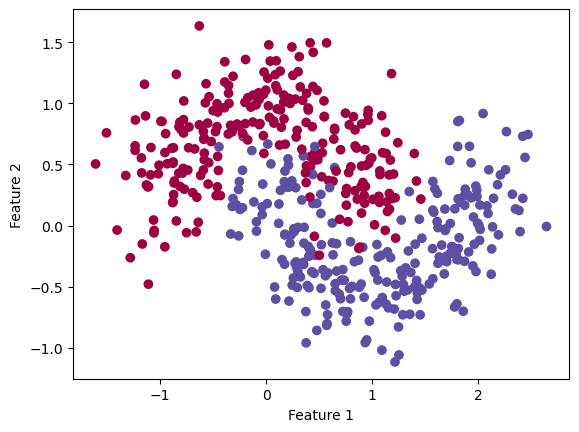

In [25]:
data_x, data_y = make_moons(500, noise=0.25, random_state=SEED)
print(f'{data_x.shape}|||{data_y.shape}')
plt.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral)
plt.gca().set(xlabel='Feature 1', ylabel='Feature 2')
plt.show()

  0%|          | 0/251 [00:00<?, ?it/s]

epoch 0 training loss = 1.045374313127924
epoch 0 val loss=0.7386715104466345, val acc = 56.99999999999999
epoch 50 training loss = 0.3599508614119558
epoch 50 val loss=0.3679008947506793, val acc = 85.0
epoch 100 training loss = 0.30057398341909586
epoch 100 val loss=0.3292025936858951, val acc = 85.0
epoch 150 training loss = 0.2746145343203038
epoch 150 val loss=0.3059888419975536, val acc = 86.0
epoch 200 training loss = 0.25579188110245704
epoch 200 val loss=0.290540740121137, val acc = 87.0
epoch 250 training loss = 0.2383886309431489
epoch 250 val loss=0.27717276621529074, val acc = 88.0
Runtime of the algorithm is  0.482  seconds


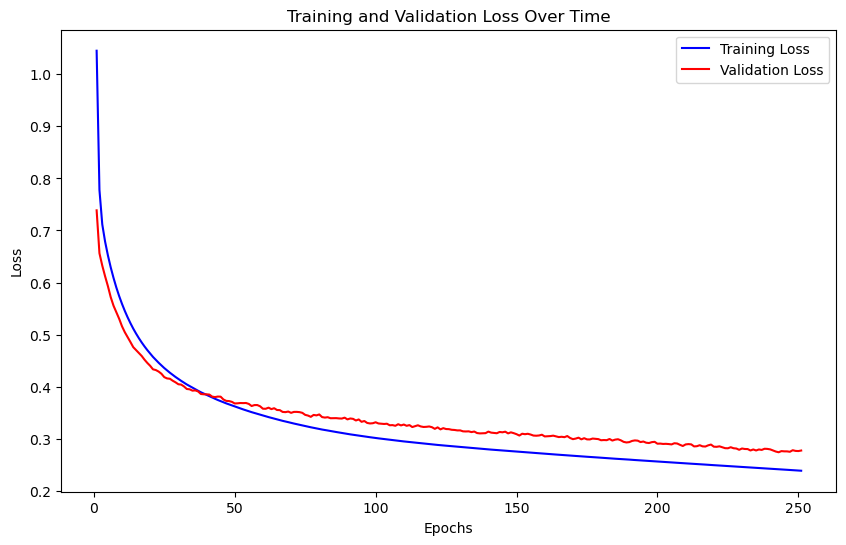

In [29]:
X_train, X_val, Y_train, Y_val = train_test_split(data_x, data_y, test_size = 0.2, random_state=SEED)

nn = NeuralNetwork([2, 60, 40, 20, 2], mode='classification', activation='sigmoid', optimizer = 'minibatch', batch_size=64)
start = time.time()
history, val_hist = nn.fit(X_train, Y_train, X_val, Y_val, epochs = 251, lr = 0.02)

# end time
end = time.time()
print("Runtime of the algorithm is ",round((end - start),3)," seconds")

# Plot both training and val loss history
plot_losses(history, val_hist)

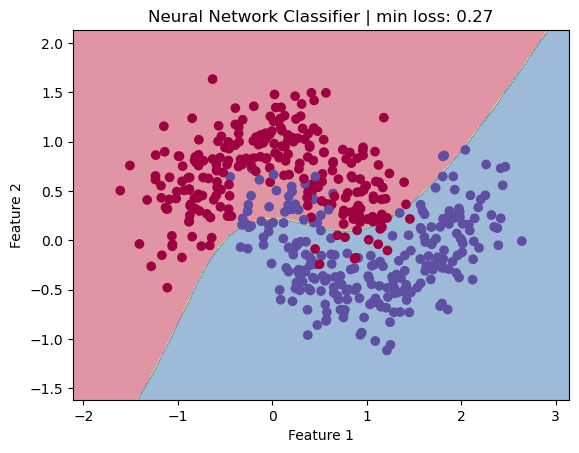

In [30]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x),
                       x_min, x_max, y_min, y_max,
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral)
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier | min loss: {np.min(val_hist):.2f}')
plt.show()